# Basic TensorFlow with GPU

![TensorFlow logo](http://advancedspark.com/img/tensorflow-logo.png)
 

In [43]:
import tensorflow as tf

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

logdir = '/root/pipeline/logs/tensorflow'

import numpy as np
import matplotlib.pyplot as plt
import datetime

from tensorflow.python.framework import ops
from tensorflow.python.platform import gfile

from IPython.display import clear_output, Image, display, HTML

Multiply 2 matrices

In [44]:
matrix1 = tf.placeholder("float",name="matrix1")
matrix2 = tf.placeholder("float",name="matrix2")
product = tf.matmul(matrix1, matrix2)

In [45]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
result  = sess.run(product,feed_dict={matrix1: [[3., 3.]], matrix2: [[6.],[6.]]})
print result
sess.close()

[[ 36.]]


Sessions must be closed to release resources.  We may use the 'with' syntax to close sessions automatically when completed.

In [46]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    with tf.device("/gpu:0"):
      result = sess.run(product,feed_dict={matrix1: [[3., 3.]], matrix2: [[6.],[6.]]})
      print result

[[ 36.]]


Here we have included a device reference, which will determine which GPU to use for operations.  Indexing of devices starts at 0.

We may define variables that maintain their properties across executions of the graph.  For instance, a variable is used to track runs of the session.

First, create a Variable, that will be initialized to the scalar value 0.  Then, create an Op to add one to `state`.  Variables must be initialized through the use of an 'init' Op after having launched the graph.

In [47]:
state = tf.Variable(0, name="counter")

one = tf.constant(1)
new_value = tf.add(state, one)
update = tf.assign(state, new_value)

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
  sess.run(init_op)
  print sess.run(state)
  for _ in range(3):
    sess.run(update)
    print sess.run(state)

0
1
2
3


# Linear Regression

In the following example, we perform simple linear regression.  The target data is $y = 2x + \eta $ where $ \eta $ has the distribution ~ $ N(0, \sigma^2) $

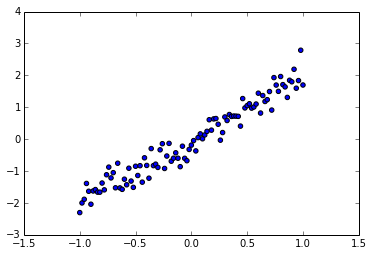

In [48]:
%matplotlib inline
x_batch = np.linspace(-1, 1, 101)
y_batch = x_batch * 2 + np.random.randn(*x_batch.shape) * 0.3
plt.scatter(x_batch, y_batch)

We can initialize input Ops using the placeholder function

In [49]:
x = tf.placeholder(tf.float32, shape=(None,), name="x")
y = tf.placeholder(tf.float32, shape=(None,), name="y")

We also create a variable for the weights and note that a NumPy array is convertible to a Tensor.

In [50]:
w = tf.Variable(np.random.normal(), name="W")

Our approach here is to perform gradient descent to update a predictor, y_pred, using the least squares cost function.  Updating y_pred is simply done through a matrix multiplication similar to what we have performed earlier.

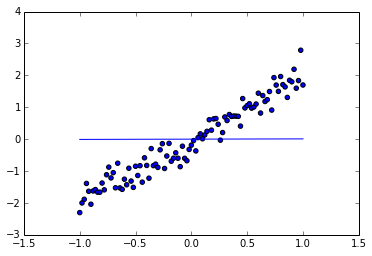

In [51]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
y_pred = tf.mul(w, x)
y0 = sess.run(y_pred, {x: x_batch})
plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y0)

cost = tf.reduce_mean(tf.square(y_pred - y))
summary_op = tf.scalar_summary("cost", cost)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(cost)

The initial predictor has little relation to the data.

We've selected the optimizer to reduce the cost function, which is the sum of squared differences with the data.  We can then define a Summary Writer which will output logs and enable visualizations in TensorBoard. 

We start our optimizer:

1.40821
1.23409
1.08283
0.951454
0.837334
0.738206
0.652102
0.577309
0.512342
0.455911
0.406893
0.364315
0.327331
0.295205
0.2673
0.243062
0.222007
0.203719
0.187833
0.174034
0.162048
0.151637
0.142594
0.134738
0.127915
0.121988
0.116839
0.112368
0.108483
0.105109


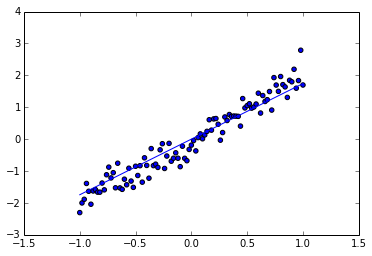

In [52]:
summary_writer = tf.train.SummaryWriter(logdir, sess.graph_def)
for t in range(30):
    cost_t, summary, _ = sess.run([cost, summary_op, train_op], {x: x_batch, y: y_batch})
    summary_writer.add_summary(summary, t)
    print cost_t.mean()

y_pred_batch = sess.run(y_pred, {x: x_batch})  
plt.figure(1)
plt.scatter(x_batch, y_batch)
plt.plot(x_batch, y_pred_batch)

In [53]:
# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Check you're able to navigate around TensorBoard and navigate to the items below visualizing the graph, weights, and gradient descent parameters.

![TensorBoard graph](tensorboard1.png)


![TensorBoard weights](tensorboard2.png)


![TensorBoard gradient descent](tensorboard3.png)

# Multilayer Convolutional Network

In the following section, we use convolutional layers, a crucial tool in networks providing advances over traditional image recognition techniques on large datasets.  Here, we work with a dataset consisting of handwritten integers, the MNIST dataset.  

We use a class that stores the MNIST training, validation, and test sets as NumPy arrays.

We first initialize the weights and biases.  Weights are typically set to a low noise-like background to avoid 0 gradients providing a small perturbation to the start of optimization.

In [54]:
import tensorflow.examples.tutorials.mnist.input_data as input_data

#import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We may now define a helper function calling the convolution with a stride of one and zero padded to match the input and output size and standard 2x2 max pooling layers.  Under the hood, the TensorFlow functions use the NVIDIA cuDNN (CUDA Deep Neural Network) library to perform assembly optimized implementations on the GPU.

In [55]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Convolutional + Pooling Layers

In [56]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Regularization / Dropout Layer Avoids Overfitting

In [57]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

Softmax Layer Produces Class Probabilities

In [58]:
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

We apply a Dropout layer, which undersamples the neurons during training to regularize (reduce overfitting) of our model.

We now train our model using the similar cross entropy as the objective function and the more robust Adam optimizer. The output is logged for every 100th iteration in the training process.

In [4]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.initialize_all_variables())
for i in range(100):
  batch = mnist.train.next_batch(50)
  if i%10 == 0:
    train_accuracy = accuracy.eval(session=sess, feed_dict={
      x:batch[0], y_: batch[1], keep_prob: 1.0})
    print "step %d, training accuracy %g"%(i, train_accuracy)
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print "test accuracy %g"%accuracy.eval(session=sess, feed_dict={
  x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})


InvalidArgumentError: Cannot assign a device to node 'init_1': Could not satisfy explicit device specification '/device:GPU:0'
	 [[Node: init_1 = NoOp[_device="/device:GPU:0"]()]]
Caused by op u'init_1', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-6ae9f891b6d7>", line 6, in <module>
    sess.run(tf.initialize_all_variables())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 711, in initialize_all_variables
    return initialize_variables(all_variables())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 700, in initialize_variables
    return control_flow_ops.no_op(name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_control_flow_ops.py", line 134, in no_op
    return _op_def_lib.apply_op("NoOp", name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 661, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2040, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()


In [60]:
tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Now try tuning the model for better performance. There are many options:

- Add more layers
- Increase the number of nodes
- Use different types of activation function
- Increase the number of epochs

See if you can reach over 98% accuracy

## Sequence Autoencoder
In the next example, we demonstrate an autoencoder which learns a lower-dimensional representation of sequential input data.

In [61]:
sess.close()
ops.reset_default_graph()
from tensorflow.models.rnn import rnn_cell, seq2seq
sess = tf.InteractiveSession()
seq_length = 5
batch_size = 64

vocab_size = 7
embedding_dim = 50

memory_dim = 100

For each time point, we define an associated Tensor and label.  Finally, a weights constant is invariant with respect to time.

In [62]:
enc_inp = [tf.placeholder(tf.int32, shape=(None,),
                          name="inp%i" % t)
           for t in range(seq_length)]

labels = [tf.placeholder(tf.int32, shape=(None,),
                        name="labels%i" % t)
          for t in range(seq_length)]

weights = [tf.ones_like(labels_t, dtype=tf.float32)
           for labels_t in labels]

dec_inp = ([tf.zeros_like(enc_inp[0], dtype=np.int32, name="GO")]
           + enc_inp[:-1])

prev_mem = tf.zeros((batch_size, memory_dim))

We have defined a decoder input with the name "GO" and dropped the final value of the encoder. We now initialize the seq2seq embedding structure with the previously defined values and apply a loss function that is the cross-entropy across each item in the sequence.

In [63]:
cell = rnn_cell.GRUCell(memory_dim)
dec_outputs, dec_memory = seq2seq.embedding_rnn_seq2seq(enc_inp, dec_inp, cell, vocab_size, vocab_size)

loss = seq2seq.sequence_loss(dec_outputs, labels, weights, vocab_size)

We specify the outputs during training as the loss and the magnitude of activations.

In [64]:
tf.scalar_summary("loss", loss)
magnitude = tf.sqrt(tf.reduce_sum(tf.square(dec_outputs[1])))

tf.scalar_summary("magnitude at t=1", magnitude)

summary_op = tf.merge_all_summaries()

logdir = '~/'
summary_writer = tf.train.SummaryWriter(logdir, sess.graph_def)

We specify the learning rate and momentum to our momentum operator.  

In [65]:
learning_rate = 0.05
momentum = 0.9
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
train_op = optimizer.minimize(loss)

What would happen if we tripled our learning rate and momentum? (answer at end).

We train in batches on the GPU.

In [1]:
def train_batch(batch_size):
    X = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
         for _ in range(batch_size)]
    Y = X[:]
    X = np.array(X).T
    Y = np.array(Y).T
    feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
    feed_dict.update({labels[t]: Y[t] for t in range(seq_length)})
    _, loss_t, summary = sess.run([train_op, loss, summary_op], feed_dict)
    return loss_t, summary

with tf.device('/gpu:0'):
    sess.run(tf.initialize_all_variables())
    for t in range(500):
        loss_t, summary = train_batch(batch_size)
        summary_writer.add_summary(summary, t)

NameError: name 'tf' is not defined

In [ ]:
summary_writer.flush()

We can now test our lower dimensional autoencoder by passing data through the embedding to determine if the similar input was recovered.

In [ ]:
X_batch = [np.random.choice(vocab_size, size=(seq_length,), replace=False)
           for _ in range(10)]
X_batch = np.array(X_batch).T

feed_dict = {enc_inp[t]: X_batch[t] for t in range(seq_length)}
dec_outputs_batch = sess.run(dec_outputs, feed_dict)

print(X_batch)

[logits_t.argmax(axis=1) for logits_t in dec_outputs_batch]

tmp_def = rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def) 

At this point, we may return and implement the changes in learning rate and momemtum to inform us on question 1.

## Acknowledgements

Significant content from TensorFlow documentation [here](https://www.tensorflow.org/versions/0.6.0/tutorials/mnist/pros/index.html#build-a-multilayer-convolutional-network), and Aymeric Damien's repository [here](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/multigpu_basics.py). Original model parallel code is licensed under the Apache 2.0 license

What would happen if we tripled our learning rate and momentum? 

Increasing the learning rate and momentum comes at the risks of skipping local minima.  Here, the learning rate and momentum results in a search that is too coarse and unable to converge.  Increasing momentum reduces the effect of the current time point compared to the previous time points.  This must be balanced with regards to the optimization landscape.  

What is the effect of performing the summation on a GPU device?

The time is increased marginally.  The extra time stems from transferring data from two GPUs to one GPU (luckily the GPU memory is large enough to fit extra copies or otherwise the operation would fail).  There is a degree of parallelism that is exploited during matrix summations.


What is the largest batch size that can be used?

The maximum batch size is 8192 for a 12 GB GPU, but diminishing returns are observed after 2048 batch size. 